## Import Libraries

In [1]:
! pip install -q sentence-transformers
! pip install -q transformers sentencepiece
! pip install -q ipywidgets
! pip install -q streamlit_jupyter
! pip install -q plotly

In [2]:
import pandas as pd
import re
from ipywidgets import interact
from IPython.display import display, HTML, Markdown
import torch
torch.cuda.is_available()

False

## Pre-processing Product Data

### Read Input CSV

In [20]:
# Read the CSV file
df = pd.read_csv('products_20000.csv')

# Drop unused columns
df = df.drop(columns=['global_product_gtin', 'product_gtin', 'product_type'])

# Remove global products which only have one distributor or manufacturer product
ids = df['global_product_id'].value_counts()
df = df[df['global_product_id'].isin(ids[ids > 1].index.tolist())]

df

,global_product_id,product_id,sku,product_name
10003,890969,5,12223023,TRIO Cheese Sauce Mix 32oz (Pack of 8)
10006,1834383,8,8501534,Minor'S Sweet Sour Sauce .5 Gal Jug
10008,66131,10,11001258,Discontinued Coffee Mate Original Packets Powd...
10012,1262971,14,11000374,Nestle Coffee-Mate Coffee Creamer Hazelnut Art...
10017,1311414,19,11000373,Nestle Coffee Mate Coffee Creamer French Vanil...
...,...,...,...,...
19087,8509,9178,3474,YELLOW CUPCAKE
19089,8511,9180,11619,ZERTS PUDDING CAKE BATTER
19091,1200734,9183,342300,NEW YORK-STYLE ECLAIR CHOCOLATE ICED BAVARIAN ...
19094,1323442,9187,162540,GLUTEN FREE 11.75 SEASONED CAULIFLOWER PIZZA C...


### Clean product names

In [13]:
def clean_text(product):
    text = product['product_name']
    text = re.sub(r"&", " and ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\t", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(" +", " ", text)
    return text.strip().lower()

df["product_name"] = df.apply(clean_text, axis=1)

df

0
0


## Evaluate Product to Embeddings Model

### Download Fine-Tuned Model

In [ ]:
import os
import boto3
import botocore

def download_directory_from_s3(
    s3_directory_key, local_directory, bucket_name="ai-ml-training-models"
):
    print(f"Starting download: {s3_directory_key}")

    s3 = boto3.resource("s3")
    bucket = s3.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=s3_directory_key):
        if not obj.key.endswith("/"):  # Avoid creating empty directories
            # Construct local filepath
            local_file_path = os.path.join(
                local_directory, obj.key.replace(s3_directory_key, "")
            )
            os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
            try:
                bucket.download_file(obj.key, local_file_path)
                print(f"Downloaded {obj.key} to {local_file_path}")
            except botocore.exceptions.ClientError as e:
                print(f"Unable to download file: {obj.key}")

    print("Finished downloading")

download_directory_from_s3(
    s3_directory_key="GTIN_Anomaly/models/ProductNameModelV1/",
    local_directory="models/ProductNameModelV1/",
)

### Create Sentence Transformer Model

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer("models/ProductNameModelV1")
model.eval()

def get_cosine_similarity(df):
    product_names = df["product_name"].to_list()
    products_embeddings = model.encode(product_names, convert_to_tensor=False)
    cosine_similarity_matrix = cosine_similarity(products_embeddings)
    return products_embeddings, cosine_similarity_matrix

### Select Global Product ID for Anomaly Detection

In [ ]:
cosine_similarity_matrix = None
selected_skus = None
selected_products = None
products_embeddings = None

def show_selected_gid(gid):
    global cosine_similarity_matrix, selected_skus, selected_products, products_embeddings
    selected_products_df = df[df["global_product_id"] == gid]
    selected_skus = selected_products_df["sku"].apply(str).to_list()
    selected_products = selected_products_df["product_name"].to_list()

    title = f"# GID - {gid} (Products - {len(selected_skus)})"
    display(Markdown(title))

    products_embeddings, cosine_similarity_matrix = get_cosine_similarity(selected_products_df)

    show_df = selected_products_df[["global_product_id", "sku", "product_name"]]
    display(HTML(show_df.to_html()))

interact(show_selected_gid, gid=df['global_product_id'].unique().tolist())

interactive(children=(Dropdown(description='l4_cat', options=('1804 : Chili Dog or Hot Dog Sauce', '1801 : Che…

### Plot Cosine Similarity Matrix

In [ ]:
import plotly.express as px

fig = px.imshow(cosine_similarity_matrix,
                labels=dict(x="X", y="Y", color="Cosine Similarity"),
                text_auto=".2f",
                x=selected_products,
                y=selected_products,
                range_color=[0, 1],
                color_continuous_scale='jet'
                )
# Update x-axis and y-axis to hide tick labels
fig.update_xaxes(tickvals=list(range(len(selected_skus))), ticktext=selected_skus, side="top", tickangle=270)
fig.update_yaxes(tickvals=list(range(len(selected_skus))), ticktext=selected_skus)
fig.show()

### 3D Visualization of Reduced Product Embeddings

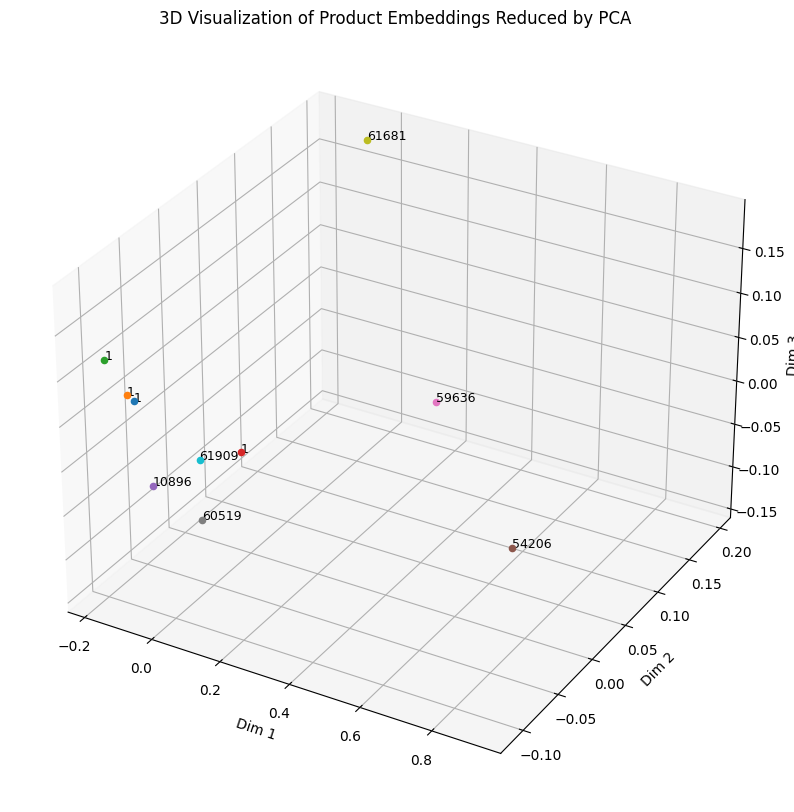

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection

# Initialize PCA to reduce to 3 dimensions for visualization
pca = PCA(n_components=3)

# Fit PCA on the embeddings and transform the embeddings to the reduced space
reduced_embeddings = pca.fit_transform(products_embeddings)

# Plot the reduced embeddings in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, product in enumerate(selected_skus):
    ax.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2])
    ax.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], product, fontsize=9)

ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
ax.set_title('3D Visualization of Product Embeddings Reduced by PCA')
plt.show()
